# HSCT survival: XGBoost model

## Notebook set-up

In [1]:
import pickle
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import configuration as config
import functions.helper as helper_funcs
import functions.plotting as plot_funcs

pd.set_option('display.max_rows', 500)

# Data files
data_df_file=f'{config.DATA_PATH}/processed/02.1-multicollinear_encoded_all_imputed_data_df.parquet'
raw_data_file=f'{config.DATA_PATH}/raw/train.csv'
hyperparameter_tuning_results=f'{config.DATA_PATH}/results/data/05.3-hyperparameter_tuning_results.csv'
coxph_survival_probabilities_file=f'{config.DATA_PATH}/processed/04.1-coxPH_160_week_survival_probabilities.parquet'
weibullaft_survival_probabilities_file=f'{config.DATA_PATH}/processed/04.2-weibullAFT_160_week_survival_probabilities.parquet'

# Model files
tuned_model_file=f'{config.MODELS_PATH}/05.3-XGBoost_engineered_features_tuned.pkl'

# Scoring results
training_scores_file=f'{config.DATA_PATH}/results/data/05.3-training_scores.csv'
testing_scores_file=f'{config.DATA_PATH}/results/data/05.3-testing_scores.csv'

retune_model=True

## 1. Load data

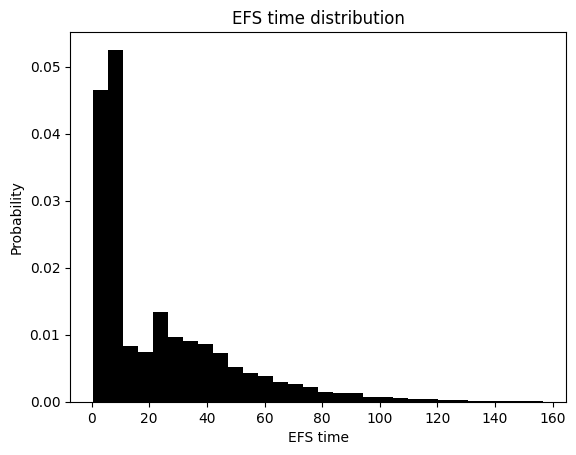

Training features: (28800, 151)


In [2]:
# Load the data
data_df=pd.read_parquet(data_df_file)

# Load and preserve race group for scoring
raw_data=pd.read_csv(raw_data_file)
data_df['race_group']=raw_data['race_group']

# Load the survival probabilities and add them to the data
survival_probabilities=pd.read_parquet(coxph_survival_probabilities_file)
data_df=pd.concat([data_df, survival_probabilities.reset_index(drop=True)], axis=1)
survival_probabilities=pd.read_parquet(weibullaft_survival_probabilities_file)
data_df=pd.concat([data_df, survival_probabilities.reset_index(drop=True)], axis=1)

# Clean up column names
data_df.columns=data_df.columns.str.replace('[\\[\\]<]', '', regex=True)

# Take a quick look at the target
plt.title('EFS time distribution')
plt.hist(data_df['efs_time'], density=True, bins=30, color='black')
plt.xlabel('EFS time')
plt.ylabel('Probability')
plt.show()

print(f'Training features: {data_df.shape}')

In [3]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28800 entries, 0 to 28799
Columns: 151 entries, hla_match_c_high to weibullaft_survival_probabilities
dtypes: float64(29), int32(121), object(1)
memory usage: 20.1+ MB


## 2. Data preparation

### 2.1. Train-test split

In [4]:
training, testing=train_test_split(data_df, test_size=0.33, random_state=315)

training_df=pd.DataFrame(training, columns=data_df.columns)
testing_df=pd.DataFrame(testing, columns=data_df.columns)

### 2.2. Save and remove training & testing race group

In [5]:
training_race_group=training_df['race_group']
testing_race_group=testing_df['race_group']

training_df.drop('race_group', axis=1, inplace=True)
testing_df.drop('race_group', axis=1, inplace=True)

### 2.3. Make features and labels

In [6]:
training_labels_df=training_df[['efs', 'efs_time', 'coxph_survival_probabilities', 'weibullaft_survival_probabilities']].copy()
training_features_df=training_df.drop(['efs', 'efs_time', 'coxph_survival_probabilities', 'weibullaft_survival_probabilities'], axis=1)

testing_labels_df=testing_df[['efs', 'efs_time', 'coxph_survival_probabilities', 'weibullaft_survival_probabilities']].copy()
testing_features_df=testing_df.drop(['efs', 'efs_time', 'coxph_survival_probabilities', 'weibullaft_survival_probabilities'], axis=1)

## 3. Label transformation testing

Label type: efs_time


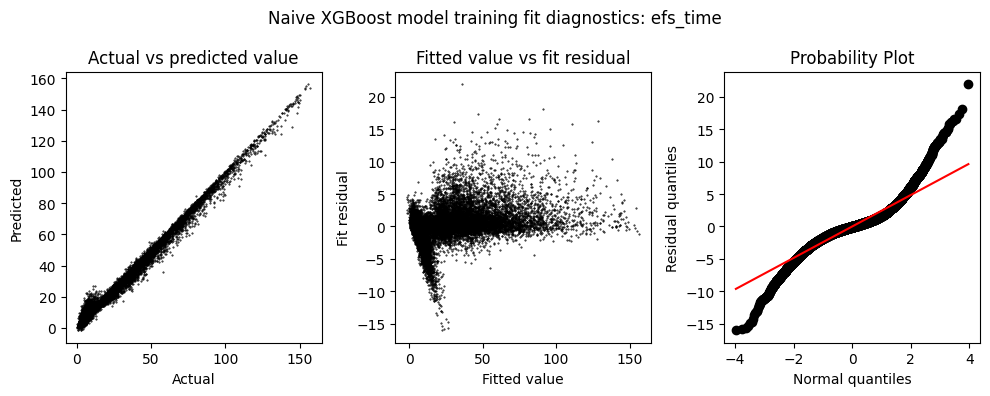

Label type: coxph_survival_probabilities


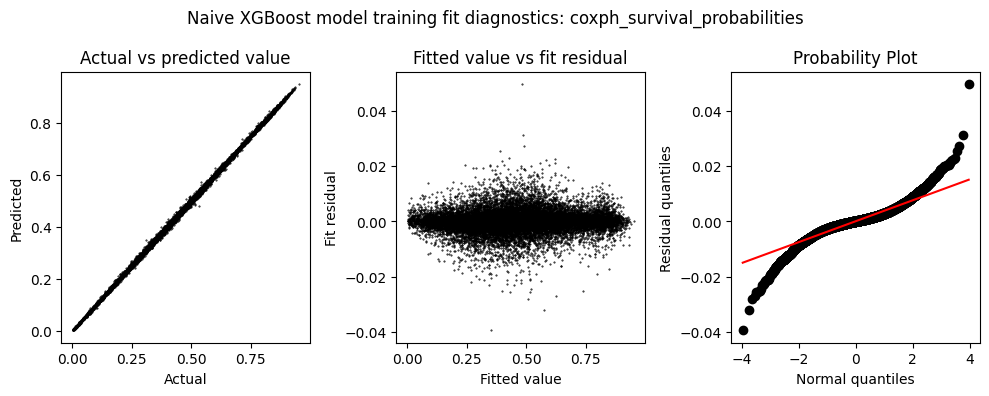

Label type: weibullaft_survival_probabilities


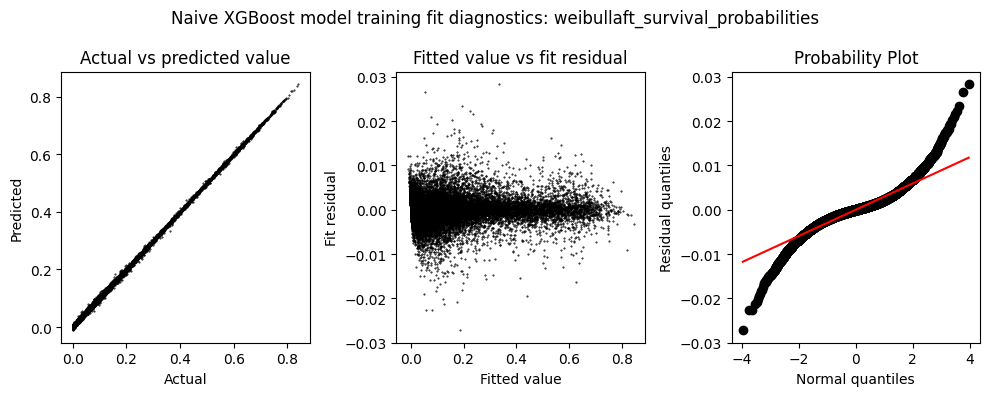

In [7]:
label_types=['efs_time', 'coxph_survival_probabilities', 'weibullaft_survival_probabilities']

training_score_results={
    'Model': [],
    'RMSE': [],
    'C-index': [],
    'Stratified C-index': []
}

testing_score_results={
    'Model': [],
    'RMSE': [],
    'C-index': [],
    'Stratified C-index': []
}

for label_type in label_types:

    print(f'Label type: {label_type}')

    # XGBoost Model
    xgb_params={
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'seed': 315
    }

    # Train on the complete training set
    dtraining=xgb.DMatrix(training_features_df, label=training_labels_df[label_type])

    naive_model=xgb.train(
        xgb_params,
        dtraining,
        num_boost_round=1000,
        evals=[(dtraining, 'training')],
        early_stopping_rounds=10,
        verbose_eval=0
    )

    # Make predictions for the training set
    training_predictions=naive_model.predict(dtraining)

    # Make fit diagnostic plots
    plot=plot_funcs.prediction_eval_plot(
        f'Naive XGBoost model training fit diagnostics: {label_type}',
        training_predictions,
        training_labels_df[label_type]
    )

    # Save the plot
    plot.savefig(f'{config.DATA_PATH}/results/plots/05.3-fit_diagnostics_engineered_features_naive_xgb_model_{label_type}.jpg', dpi=300)
    plot.show()

    # Score the training set predictions for RMSE, C-index and stratified C-index
    training_score_results=helper_funcs.score_predictions(
        model_description=f'Naive: {label_type}',
        predictions=training_predictions,
        labels_df=training_labels_df,
        race_group=training_race_group,
        results=training_score_results,
        label_type=label_type
    )

## 4. Hyperparameter tuning

In [8]:
# Manually choose best label transformation based on above plots
label_type='coxph_survival_probabilities'

# Train or load model as desired
if retune_model == True:

    # Define the hyperparameter search space
    search_space={
        'objective': ['reg:squarederror'],
        'eval_metric': ['rmse'],
        'seed': [315],
        'learning_rate': [0.0125, 0.025, 0.05, 0.1],
        'max_depth': [2, 3, 4, 5],
        'gamma': [0.01, 0.02, 0.04],
        'subsample': [0.5, 0.6, 0.7]
    }

    results_df, tuned_model=helper_funcs.xgb_hyperparameter_search(
        search_space,
        training_features_df,
        training_labels_df[label_type]
    )

    # Save the tuned model
    with open(tuned_model_file, 'wb') as output_file:
        pickle.dump(tuned_model, output_file)

    # Save the hyperparameter tuning results
    results_df.to_csv(hyperparameter_tuning_results)
    
elif retune_model == False:

    # Load the last tuned model
    with open(tuned_model_file, 'rb') as input_file:
        tuned_model=pickle.load(input_file)

    # Load the results from the last tuning run
    results_df=pd.read_csv(hyperparameter_tuning_results)

Winning hyperparameters: {'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'seed': 315, 'learning_rate': 0.1, 'max_depth': 3, 'gamma': 0.01, 'subsample': 0.5}


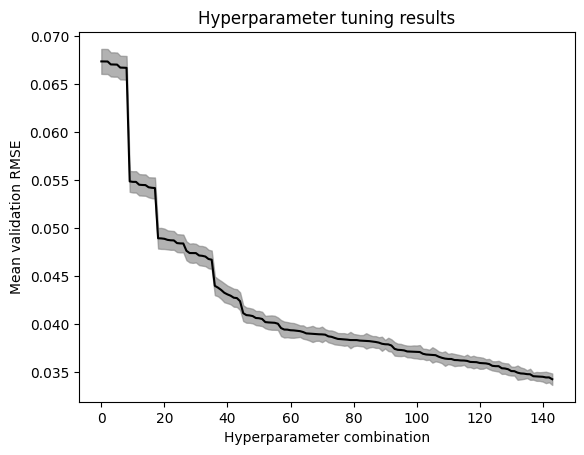

In [9]:
plt.title('Hyperparameter tuning results')
plt.plot(results_df.index, results_df['RMSE mean'], color='black')

plt.fill_between(
    results_df.index,
    results_df['RMSE mean'] - results_df['RMSE standard deviation'],
    results_df['RMSE mean'] + results_df['RMSE standard deviation'],
    color='gray',
    alpha=0.6
)

plt.xlabel('Hyperparameter combination')
plt.ylabel('Mean validation RMSE')
plt.show()

## 5. Evaluate tuned model

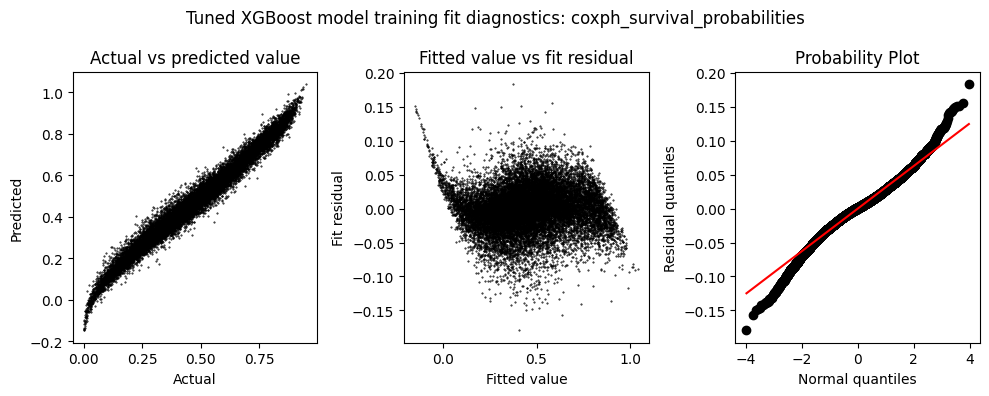

In [10]:
# Make predictions on the training and testing sets
training_predictions=tuned_model.predict(dtraining)

dtesting=xgb.DMatrix(testing_features_df, label=testing_labels_df[label_type])
testing_predictions=tuned_model.predict(dtesting)

# Make diagnostic plots for the training set
plot=plot_funcs.prediction_eval_plot(
    f'Tuned XGBoost model training fit diagnostics: {label_type}',
    training_predictions,
    training_labels_df[label_type]
)

# Save the plot
plot.savefig(f'{config.DATA_PATH}/results/plots/05.3-fit_diagnostics_tuned_engineered_features_xgb_model_{label_type}.jpg', dpi=300)
plot.show()

# Score the training set predictions for RMSE, C-index and stratified C-index
training_score_results=helper_funcs.score_predictions(
    model_description=f'Tuned: {label_type}',
    predictions=training_predictions,
    labels_df=training_labels_df,
    race_group=training_race_group,
    results=training_score_results,
    label_type=label_type
)

# Score the test set predictions for RMSE, C-index and stratified C-index
testing_score_results=helper_funcs.score_predictions(
    model_description=f'Tuned: {label_type}',
    predictions=testing_predictions,
    labels_df=testing_labels_df,
    race_group=testing_race_group,
    results=testing_score_results,
    label_type=label_type
)

## 6. Model comparison

### 6.1. Training set performance

In [11]:
training_score_results_df=pd.DataFrame.from_dict(training_score_results)
training_score_results_df.to_csv(training_scores_file, index=False)
training_score_results_df.head()

,Model,RMSE,C-index,Stratified C-index
0,Naive: efs_time,2.541895,0.073739,0.502764
1,Naive: coxph_survival_probabilities,0.003944,0.005100,0.497750
2,Naive: weibullaft_survival_probabilities,0.003079,0.011577,0.495021
3,Tuned: coxph_survival_probabilities,0.031688,0.042501,0.498497


### 6.2. Testing set performance

In [12]:
testing_score_results_df=pd.DataFrame.from_dict(testing_score_results)
testing_score_results_df.to_csv(testing_scores_file, index=False)
testing_score_results_df.head()

,Model,RMSE,C-index,Stratified C-index
0,Tuned: coxph_survival_probabilities,0.033639,0.045279,0.481219
